In [ ]:
!pip install --upgrade pip
!pip install fosforml numpy pandas matplotlib scikit-learn seaborn python-dateutil
!pip uninstall urllib3 -y
!pip install urllib3==1.26.15
!pip install fosforml 
!pip install fosforio
!pip install -U cloudpickle

In [ ]:
!pip install seaborn scipy xgboost pandas dice-ml tabulate numpy scikit-learn pandas-profiling plotly matplotlib scipy statsmodels seaborn pydantic-settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from scipy.stats.mstats import winsorize
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import joblib
from fosforml import *
from fosforml.constants import MLModelFlavours
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [2]:
from fosforml.model_manager.snowflakesession import get_session

my_session = get_session()

In [3]:
df = 'FRAUD_DETECTION_ANALY_MASTER_TABLE'

In [4]:
sf_df = my_session.sql("select * from {}".format(df))

In [5]:
import pandas as pd
pandas_df = sf_df.to_pandas()

In [6]:
print(pandas_df.isnull().sum())

CREDIT_LIMIT                          0
ACCOUNT_OPENING_DATE                  0
LAST_LOGIN                            0
CUSTOMER_SEGMENT                      0
ACCOUNT_TYPE                          0
DEVICE_USED                           0
NAME                                  0
GENDER                                0
DOB                                   0
AGE                                   0
CUSTOMER_ID                           0
AGE_GROUP                             0
AGE_OF_ACCOUNT                        0
FREQUENCY_OF_TRANSACTIONS             0
CUSTOMER_LOYALTY_SCORE                0
NUMBER_OF_REFUNDS                     0
NUMBER_OF_CHARGEBACKS                 0
CREDIT_UTILIZATION_RATIO              0
CHANGE_IN_SPENDING_BEHAVIOR           0
TRANSACTION_VELOCITY                  0
CUSTOMER_LOYALTY_CATEGORY             0
TIME_SINCE_LAST_TRANSACTION           0
TRANSACTION_ID                        0
TIME                                  0
TRANSACTION_AMOUNT                    0


In [7]:
Original_df = pandas_df.copy()

In [8]:
Original_df

,CREDIT_LIMIT,ACCOUNT_OPENING_DATE,LAST_LOGIN,CUSTOMER_SEGMENT,ACCOUNT_TYPE,DEVICE_USED,NAME,GENDER,DOB,AGE,...,MONTH,ANOMALY_SCORE,FRAUD_INDICATOR,SUSPICIOUS_FLAG,PREVIOUS_FRAUD_REPORTS,CROSS_BORDER_TRANSACTION_INDICATOR,NEW_DEVICE_INDICATOR,ANAMOLY_RISK_CATEGORY,MERCHANT_RISK_CATEGORY,FRAUD_FLAG
0,30000,2017-08-17,2017-08-22,Individual,Business Account,Tablet,Andrea Garcia,Female,1991-09-12,33,...,October,0.66,0,0,2,No,No,High Risk,High Risk,No
1,15000,2017-09-13,2018-02-08,Student,Investment Account,Desktop,Victor Ray,Male,1979-04-25,45,...,February,0.26,0,0,1,No,No,Medium Risk,High Risk,No
2,40000,2017-12-31,2020-11-12,Senior,Investment Account,Tablet,Kelli Lopez,Male,1972-04-04,52,...,December,0.20,0,0,0,No,Yes,Low Risk,Very High Risk,No
3,5000,2017-04-26,2019-05-06,Student,Checking Account,Mobile,Traci Phillips,Male,1990-10-23,34,...,January,0.03,0,1,2,Yes,Yes,Low Risk,Medium Risk,No
4,25000,2019-10-13,2021-10-10,Student,Investment Account,Desktop,Eric Brooks,Female,1995-01-26,29,...,October,0.56,0,0,1,Yes,No,High Risk,Very High Risk,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,10000,2018-04-10,2019-09-06,Business,Checking Account,Other,Carol Bishop,Male,1985-11-28,39,...,June,0.39,0,0,0,No,No,Medium Risk,Low Risk,No
299996,35000,2018-10-24,2018-10-24,Business,Savings Account,Mobile,Cole Jacobson,Male,1960-06-04,64,...,July,0.66,0,0,0,No,No,High Risk,Medium Risk,No
299997,15000,2017-08-24,2017-10-21,Senior,Checking Account,Other,Wendy Bell,Male,1988-03-17,36,...,February,0.53,0,0,0,No,No,High Risk,High Risk,No
299998,5000,2019-12-19,2021-04-09,Senior,Investment Account,Desktop,James Austin,Male,1992-09-13,32,...,November,0.77,0,0,2,No,No,Very High Risk,Very High Risk,No


In [28]:
df = Original_df.drop(["TRANSACTION_ID", "CUSTOMER_ID", "DOB", "NAME", "CITY","COUNTY","STATE","YEAR","QUARTER","MONTH","AGE_GROUP","TRANSACTION_DATE","ACCOUNT_OPENING_DATE","LAST_LOGIN","TIME_OF_DAY","DAY_OF_WEEK","TIME","TIME_SINCE_LAST_TRANSACTION","FRAUD_FLAG"], axis = 1)

In [45]:
CATEGORICAL_COLUMNS = ["MERCHANT_CATEGORY","PAYMENT_METHOD","CUSTOMER_SEGMENT","ACCOUNT_TYPE","DEVICE_USED","TRANSACTION_STATUS","CROSS_BORDER_TRANSACTION_INDICATOR","NEW_DEVICE_INDICATOR","GENDER","ANAMOLY_RISK_CATEGORY","MERCHANT_RISK_CATEGORY","CUSTOMER_LOYALTY_CATEGORY","TRANSACTION_TYPE"]
NUMERICAL_COLUMNS = ["ANOMALY_SCORE","TRANSACTION_AMOUNT","CREDIT_LIMIT","AGE_OF_ACCOUNT","FREQUENCY_OF_TRANSACTIONS","MERCHANT_RISK_SCORE","CUSTOMER_LOYALTY_SCORE","DISTANCE_FROM_HOME_ADDRESS","DISTANCE_FROM_LAST_TRANSACTION","NUMBER_OF_REFUNDS","NUMBER_OF_CHARGEBACKS","CREDIT_UTILIZATION_RATIO",
                     "CHANGE_IN_SPENDING_BEHAVIOR","TRANSACTION_VELOCITY","AGE","SUSPICIOUS_FLAG","PREVIOUS_FRAUD_REPORTS"]
LABEL_COLUMNS = ["FRAUD_INDICATOR"]
DROPPED_COLUMNS = ["TRANSACTION_ID", "CUSTOMER_ID", "DOB", "NAME", "CITY","COUNTY","STATE","YEAR","QUARTER","MONTH","AGE_GROUP","TRANSACTION_DATE","ACCOUNT_OPENING_DATE","LAST_LOGIN","TIME_OF_DAY","DAY_OF_WEEK","TIME","TIME_SINCE_LAST_TRANSACTION","FRAUD_FLAG"]
OUTPUT_COLUMNS = ["PREDICTION"]

In [46]:
# Filter feature columns
feature_columns = CATEGORICAL_COLUMNS + NUMERICAL_COLUMNS
feature_columns = [col for col in feature_columns if col in Original_df.columns]
LABEL_COLUMNS = [col for col in LABEL_COLUMNS if col in Original_df.columns]
 
# Split data into features and labels
X = Original_df[feature_columns + DROPPED_COLUMNS]
y = Original_df[LABEL_COLUMNS].values.ravel()  # Flatten to 1D array for consistency

In [47]:
# Preprocessing for numerical data
from sklearn.preprocessing import StandardScaler
numerical_transformer = StandardScaler()

In [48]:
# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

In [49]:
# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, NUMERICAL_COLUMNS),
        ('cat', categorical_transformer, CATEGORICAL_COLUMNS)
    ])

In [50]:
# Create and train the logistic regression model within a pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression())])


In [51]:
# splitting data into training set and test set

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [52]:
X_train.shape,y_test.shape

((225000, 49), (75000,))

In [53]:
# Train the model
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.94572


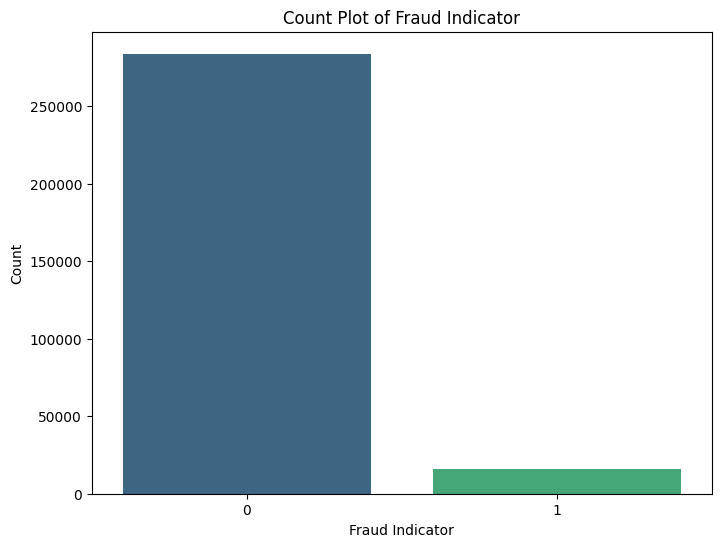

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df' and has a column 'FraudIndicator'
# Create a count plot for the 'FraudIndicator' column
plt.figure(figsize=(8, 6))  # Optional: Adjust the figure size
sns.countplot(data=Original_df, x='FRAUD_INDICATOR', palette='viridis')
plt.title('Count Plot of Fraud Indicator')
plt.xlabel('Fraud Indicator')
plt.ylabel('Count')
plt.show()
